In [26]:
''' 

Submitter : JESOON KANG, 20170937
Date : 2019. 10. 


    Assignment 4. 

-   -


'''
import matplotlib.pyplot as plt
import math
import numpy as np
import random

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import torchvision
import os


EPSILON = 1.5 * 10**-12
LAMBDA = 0.0001
LEARNING_RATE = 0.0001
BATCH_SIZE = 100
FEATURE_SIZE = 10000



In [27]:

#### Section 1. #### This Section is bringed Data_import_ex.py file.

# Image Data import & resize

transform = transforms.Compose([#transforms.Resize((256,256)),  
                                transforms.Grayscale(),		# the code transforms.Graysclae() is for changing the size [3,100,100] to [1, 100, 100] (notice : [channel, height, width] )
                                transforms.ToTensor(),])

#train_data_path = 'relative path of training data set'
train_data_path = '../data/horse-or-human/train'
trainset = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
# if shuffle=True, the data reshuffled at every epoch 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=0)  


validation_data_path = '../data/horse-or-human/validation'
valset = torchvision.datasets.ImageFolder(root=validation_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
valloader = torch.utils.data.DataLoader(valset, batch_size=100, shuffle=True, num_workers=0)  

#### Section 1 END ####


In [28]:

# sigmoid Function.
def sigmoid(z) :
    return 1 / (1 + torch.pow(math.e,-z)+ EPSILON)


def get_activation(z,type) :
    if (type == 0) :
        return sigmoid(z)
    else :
        print("Error, get_activation")
        return 0

def get_derv_activation(z,type) :
    if (type == 0) :
        return sigmoid(z)*(1-sigmoid(z))
    else :
        print("Error, get_derv_activation")
        return 0                                                                  

In [29]:
### Setting up Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Below codes activates when want to use cpu
device = torch.device('cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cpu



In [137]:

def get_origin_loss(y,a) :
    ret = -(torch.div(y,a+EPSILON) - torch.div(1-y,1-a+EPSILON))
    return ret


def get_loss(y,a) :
    ret = -(torch.div(y,a+EPSILON) - torch.div(1-y,1-a+EPSILON))
    return ret
class ML :
    def __init__(self,act1,act2,act3,L1_size,L2_size,L3_size,lr,min_loss_diff) :
        self.act_type_1 = act1
        self.act_type_2 = act2
        self.act_type_3 = act3 
        self.l1_size = L1_size
        self.l2_size = L2_size
        self.l3_size = L3_size
        self.feature_size = 10000
        self.epoch = 0
        self.lr = lr
        self.min_loss_diff = min_loss_diff
        
        self.init_weights()
        
        print("ML Object initialized")
        self.iter = 0

        self.val_acc_log = []
        self.val_loss_log = []
        self.train_acc_log = []
        self.train_loss_log = []
        self.epoch_log = []
        self.val_acc_log.append(0)
        self.val_loss_log.append(0)
        self.train_acc_log.append(0)
        self.train_loss_log.append(0)
        self.epoch_log.append(0)
        
    def init_weights(self) :
        self.w_1 = torch.FloatTensor(self.feature_size,self.l1_size).uniform_(-1,1).to(device)
        
        self.b_1 = torch.FloatTensor(1,self.l1_size).uniform_(-1,1).to(device)
        
        #torch.FloatTensor(a, b).uniform_(r1, r2)
        
        self.w_2 = torch.FloatTensor(self.l1_size,self.l2_size).uniform_(-1,1).to(device)
        self.b_2 = torch.FloatTensor(1,self.l2_size).uniform_(-1,1).to(device)

        self.w_3 = torch.FloatTensor(self.l2_size,self.l3_size).uniform_(-1,1).to(device)
        self.b_3 = torch.FloatTensor(1,self.l3_size).uniform_(-1,1).to(device)

        

        
    def training(self) :
        
        epoch = 0
        for epoch in range(0,1000000):
            train_acc_log_tmp = []
            train_loss_log_tmp = []
            val_acc_log_tmp = []
            val_loss_log_tmp = []
            

        # load training images of the batch size for every iteration
            for i, data in enumerate(trainloader):
                
                # inputs is the images
                # labels is the class of the image
                inputs, labels = data
                inputs, labels = inputs.float() , labels.float()
                # if you don't change the image size, it will be [batch_size, 1, 100, 100]

                # if labels is horse it returns tensor[0,0,0] else it returns tensor[1,1,1]
                
                self.t_data_batch = torch.squeeze(torch.FloatTensor(data[0]),3)
                
                self.t_data_batch = self.t_data_batch.view(len(data[0]),FEATURE_SIZE).to(device)
                #print("test : shape ", self.t_data_batch.shape)
                
                self.z_1 = torch.matmul(self.t_data_batch,self.w_1) + self.b_1
                #print(self.z_1)
                
                
                self.a_1 = get_activation(self.z_1,self.act_type_1)
                #print(self.a_1)
                
                self.z_2 = torch.matmul(self.a_1,self.w_2) + self.b_2

                self.a_2 = get_activation(self.z_2,self.act_type_2) # 1027 x 50

                self.z_3 = torch.matmul(self.a_2,self.w_3) + self.b_3
                #print(self.z_3)
                self.a_3 = get_activation(self.z_3,self.act_type_3) # 1027 x 1
            
                #print(self.a_3)
                self.t_yh_batch = data[1].float().unsqueeze(1).to(device)

                #print(self.a_3,self.t_yh_batch)
                acc = self.get_acc(self.a_3,self.t_yh_batch)
                loss = get_loss(self.t_yh_batch, self.a_3)
                loss = loss.mean()
                train_acc_log_tmp.append(acc)
                train_loss_log_tmp.append(loss)
                
                self.update_weights(self.t_yh_batch,self.a_3)
            
            


            train_acc = torch.tensor(train_acc_log_tmp).mean().item()
            train_loss = torch.tensor(train_loss_log_tmp).mean().item()
            print("epoch : %s, loss : %.9s, tra_acc : %.9s"%(epoch,train_loss,train_acc))
            
           

            # load validation images of the batch size for every iteration
            for i, data in enumerate(valloader):

                # inputs is the image
                # labels is the class of the image
                inputs, labels = data
                inputs, labels = inputs.float() , labels.float()
                # if you don't change the image size, it will be [batch_size, 1, 100, 100]
                
                
                # if labels is horse it returns tensor[0,0,0] else it returns tensor[1,1,1]
                
                self.v_data_batch = torch.squeeze(torch.FloatTensor(data[0]),3)
                
                self.v_data_batch = self.v_data_batch.view(len(data[0]),FEATURE_SIZE).to(device)
                
                self.z_1 = torch.matmul(self.v_data_batch,self.w_1) + self.b_1
                
                self.a_1 = get_activation(self.z_1,self.act_type_1)
                #print(self.a_1)

                self.z_2 = torch.matmul(self.a_1,self.w_2) + self.b_2
                self.a_2 = get_activation(self.z_2,self.act_type_2) # 1027 x 50

                self.z_3 = torch.matmul(self.a_2,self.w_3) + self.b_3
                self.a_3 = get_activation(self.z_3,self.act_type_3) # 1027 x 1

                self.v_yh_batch = data[1].float().unsqueeze(1).to(device)
                acc = self.get_acc(self.a_3,self.v_yh_batch)
                loss = get_loss(self.v_yh_batch, self.a_3).mean()
                
                val_acc_log_tmp.append(acc)
                val_loss_log_tmp.append(loss)
            val_acc = torch.tensor(val_acc_log_tmp).mean().item()
            val_loss = torch.tensor(val_loss_log_tmp).mean().item()
            print("                                    epoch : %s, loss : %.9s, val_acc : %.9s"%(epoch,val_loss,val_acc))

            self.train_acc_log.append(train_acc)
            self.train_loss_log.append(train_loss)
            self.val_acc_log.append(val_acc)
            self.val_loss_log.append(val_loss)
            self.epoch_log.append(epoch)
            epoch += 1
            
            tmp_idx = len(self.train_loss_log)-1
            
            loss_gap = abs(self.train_loss_log[tmp_idx]-self.train_loss_log[tmp_idx-1])
            if ( loss_gap < self.min_loss_diff) :
                print("Learning is terminated.")
                break
            else :
                print(loss_gap)

        
    def update_weights(self,t_y,a_3) :
        error_wb3 = -(torch.div(t_y,a_3+ 0.00011) - torch.div(1.0-t_y,1.0-a_3+ 0.00001)) # sum ep
        #print("error_wb3.shape :",error_wb3.shape)
        d_z_3 = error_wb3*get_derv_activation(self.z_3,self.act_type_3) #
        #print("d_z_3.shape : ",d_z_3.shape)
        #print("a_2.shape :",self.a_2.shape)
        d_w_3 = torch.matmul(self.a_2.T,d_z_3)
        d_b_3 = torch.sum(d_z_3, dim=0, keepdim=True) / self.a_2.shape[0] # mean도 됨
        
        #########
        
        error_wb2 = torch.matmul(d_z_3,self.w_3.T)
        
        d_z_2 = error_wb2*get_derv_activation(self.z_2,self.act_type_2)
        #print("self.a_1 shape : ",self.a_1.shape)
        #print("d_z_2.shape : ", d_z_2.shape)
        d_w_2 = torch.matmul(self.a_1.T,d_z_2)
        #print("d_w_2.shape : ",d_w_2.shape)
        d_b_2 = torch.sum(d_z_2, dim=0,keepdims=True) / self.a_1.shape[0]
        
   
        error_wb1 = torch.matmul(d_z_2,self.w_2.T)
        d_z_1 = error_wb1*get_derv_activation(self.z_1,self.act_type_1)
        d_w_1 = torch.matmul(self.t_data_batch.T, d_z_1) #100, 10000 / 100,10
        d_b_1 = torch.sum(d_z_1, dim=0,keepdims=True) / self.t_data_batch.shape[0]
        
        
        #print("d_w_3.shape :", d_w_3.shape)
        self.w_3 += -self.lr*d_w_3
        self.b_3 += -self.lr*d_b_3
        
        self.w_2 += -self.lr*d_w_2
        self.b_2 += -self.lr*d_b_2
        self.w_1 += -self.lr*d_w_1
        self.b_1 += -self.lr*d_b_1
        #print(b_3,b_2,b_1)
        
    def get_acc(self,yhat,y) :
        count = 0
      
        for a,b in zip(yhat,y) :
            if a >= 0.5 :
                if b == 1 :
                    count+=1
            else :
                if b == 0:
                    count +=1
        
        return count / len(yhat)

    def show_loss(self) :
        #print(self.train_loss_log)
        #print(self.val_loss_log)
        #print(self.epoch_log)
        
        tmp_1 = torch.tensor(self.train_loss_log)
        tmp_2 = torch.tensor(self.epoch_log)
       
        t1 = plt.plot(self.epoch_log,self.train_loss_log, color='orange',label='Training Loss')
        t2 = plt.plot(self.epoch_log,self.val_loss_log, color= 'red',label='Validation Loss')
        plt.title("Loss")
        plt.legend(['Training Loss','Validation Loss'])
        plt.show()
    def show_acc(self) :
        t1 = plt.plot(self.epoch_log,self.train_acc_log, color='orange',label='Training Acc')
        t2 = plt.plot(self.epoch_log,self.val_acc_log, color= 'red',label='Validation Acc')
        plt.title("Accuracy")
        plt.legend(['Training Acc','Validation Acc'])
        plt.show()



In [143]:

LEARNING_RATE = 0.001
MIN_LOSS_DIFF = 0.00001
activation_type = 0 # 0 = sigmoid

machine = ML(0,0,0,10,5,1,LEARNING_RATE,MIN_LOSS_DIFF)
dtype = torch.FloatTensor


ML Object initialized


In [144]:
machine.training()

epoch : 0, loss : 1.4123314, tra_acc : 0.5085858
                                    epoch : 0, loss : 1.0998395, val_acc : 0.5052381
1.412331461906433
epoch : 1, loss : 0.8653982, tra_acc : 0.5085858
                                    epoch : 1, loss : 0.6195037, val_acc : 0.5261904
0.5469332337379456
epoch : 2, loss : 0.5619422, tra_acc : 0.5135016
                                    epoch : 2, loss : 0.4650774, val_acc : 0.5078571
0.30345600843429565
epoch : 3, loss : 0.3486702, tra_acc : 0.5159595
                                    epoch : 3, loss : 0.3859587, val_acc : 0.4921428
0.21327194571495056
epoch : 4, loss : 0.2220674, tra_acc : 0.5208753
                                    epoch : 4, loss : 0.2253608, val_acc : 0.5078571
0.12660281360149384
epoch : 5, loss : 0.1765740, tra_acc : 0.5162289
                                    epoch : 5, loss : 0.2646793, val_acc : 0.4816666
0.04549345374107361
epoch : 6, loss : 0.1133860, tra_acc : 0.5229629
                              

KeyboardInterrupt: 

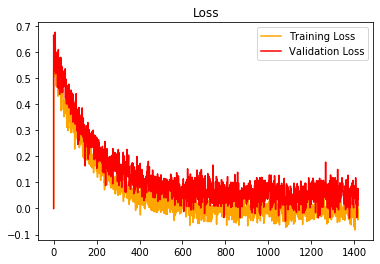

In [140]:
machine.show_loss()

In [ ]:
machine.show_acc()